In [1]:
from custom_indicators import *
from terl.envs import TradingEnv
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from gym import ObservationWrapper, RewardWrapper
from stable_baselines3.common.env_util import DummyVecEnv
from gym.spaces import Box, Dict
import numpy as np
from pyts.image import GramianAngularField, MarkovTransitionField

In [2]:
class ForexWrapper(ObservationWrapper):
    def __init__(self, env,axis=None, min_val=0, max_val=1):
        super(ForexWrapper, self).__init__(env)
        
        ct = make_column_transformer((FunctionTransformer(self.minmax_scale, kw_args={'axis':axis, 'feature_range':(min_val,max_val)}),[0,1,2,3]),
                                     (FunctionTransformer(self.minmax_scale, kw_args={'axis':axis, 'feature_range':(min_val,max_val)}),[4]),
                                     remainder='passthrough')

        gadf = GramianAngularField(image_size=self.observation_space['market_data'].shape[0])
        self.model = make_pipeline(FunctionTransformer(self.T), gadf)

        self.observation_space = Box(low=-1, high=1, 
                        shape=self.model.fit_transform(np.random.random(size=self.observation_space['market_data'].shape)).shape, 
                        dtype=np.float32)
        """
        Dict({
            'market_data':Box(low=min_val, high=max_val, 
                        shape=self.model.fit_transform(np.random.random(size=self.observation_space['market_data'].shape)).shape, 
                        dtype=np.float32),
            'portfolio_state':self.observation_space['portfolio_state']
        }) 
        """
    
    @staticmethod
    def minmax_scale(X, axis=0, feature_range=(0,1)):
        X_out = np.zeros_like(X)
        X_min = np.min(X, axis=axis)
        X_max = np.max(X, axis=axis)

        X_out = (X - X_min) / (X_max - X_min)
        X_out = X_out * (feature_range[1]-feature_range[0]) + feature_range[0]

        return X_out
    
    @staticmethod
    def T(X:np.ndarray):
        return X.T
        
    def observation(self, observation):
        observation = self.model.fit_transform(observation['market_data'])
        return observation

In [3]:
TradingEnv('TestEnvSingle').observation_space

INFO:Thread-4:numexpr.utils:NumExpr defaulting to 8 threads.


Dict(market_data:Box(-inf, inf, (60, 5), float32), portfolio_state:MultiBinary((3,)))

In [18]:
env = DummyVecEnv([lambda : TradingEnv('TestEnvSingle') for _ in range(1)])

In [19]:
gadf = GramianAngularField()

In [5]:
env.observation_space

Box(-1.0, 1.0, (5, 60, 60), float32)

In [29]:
obs = env.reset()
obs = obs['market_data'][0].T
obs.shape

(5, 60)

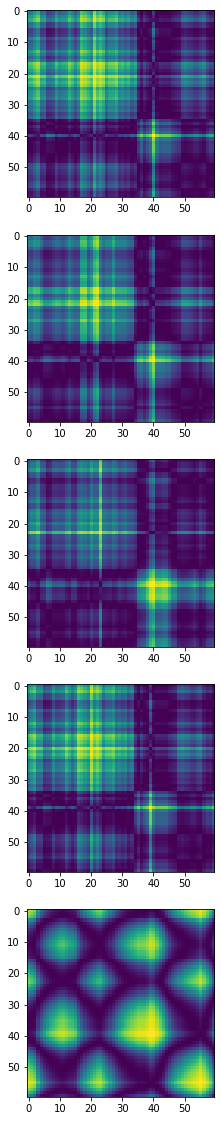

In [30]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5)
fig.set_figheight(20)
fig.set_figwidth(20)
obs_2d = gadf.fit_transform(obs)
for i in range(5):
    axs[i].imshow(obs_2d[i])

(5, 60)


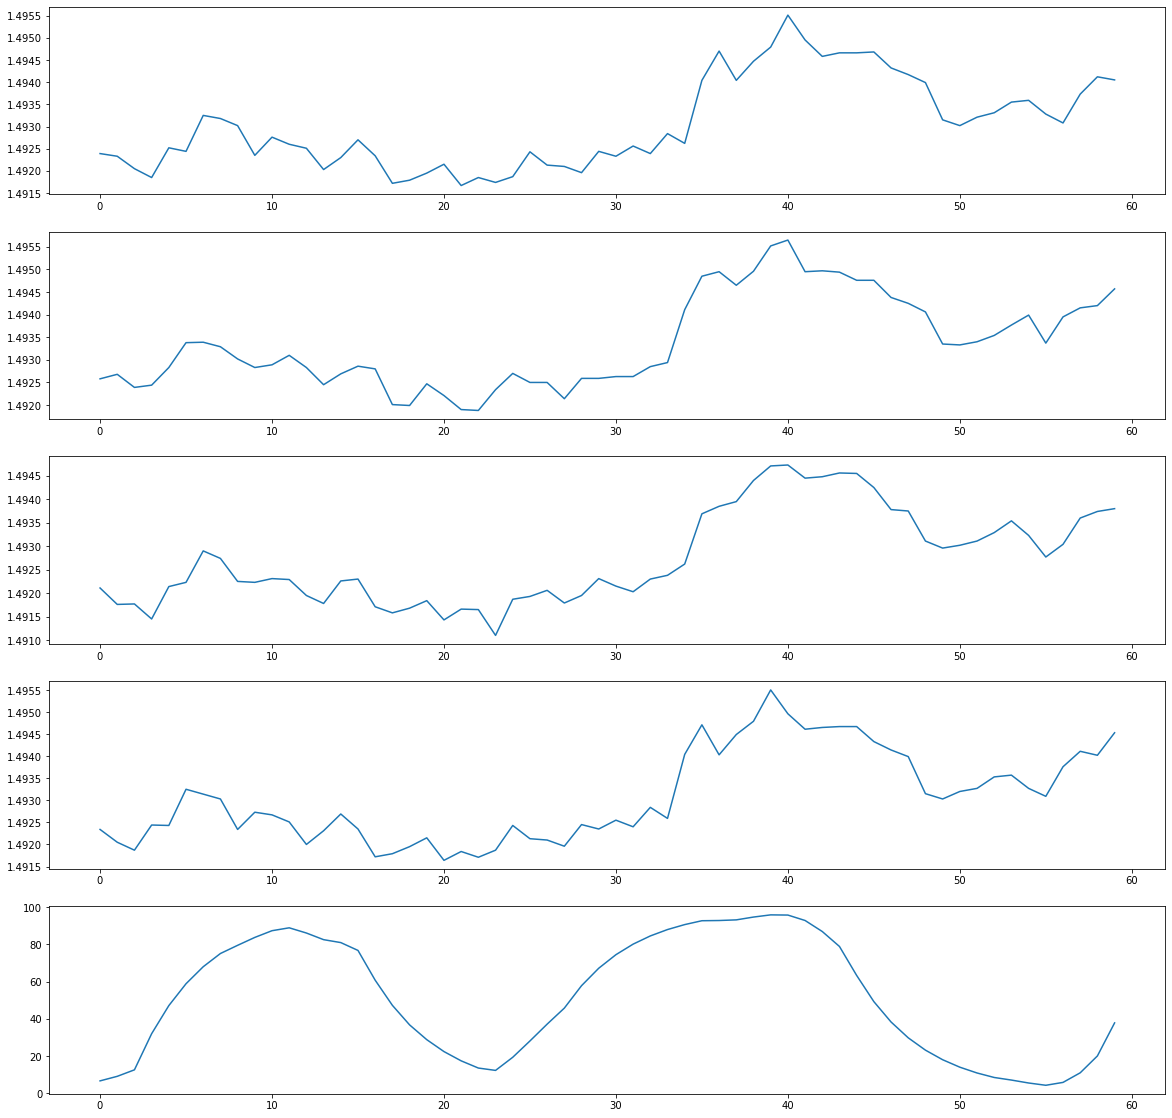

In [31]:
fig, axs = plt.subplots(5)
fig.set_figheight(20)
fig.set_figwidth(20)
print(obs.shape)
for i in range(5):
    axs[i].plot(obs[i])

In [91]:
from torch import nn
import torch

model = nn.Sequential(nn.Conv2d(5,10,2,2),
                     nn.MaxPool2d(2))

In [93]:
obs = obs.transpose((0,2,3,1))
obs.shape

(1, 60, 60, 5)

In [94]:
model(torch.Tensor(obs)).shape

RuntimeError: Given groups=1, weight of size [10, 5, 2, 2], expected input[1, 60, 60, 5] to have 5 channels, but got 60 channels instead

In [14]:
for i in range(5):
    print(np.min(obs[i]), np.max(obs[i]))

0.11006148 0.9653996
0.17926227 1.0
0.0 0.9339856
0.11321038 0.9528415
0.0 1.0


In [12]:
gadf = GramianAngularField(method="difference")
obs2 = gadf.fit_transform(obs)
obs2.shape

(5, 60, 60)

In [13]:
obs2 = obs2.transpose((1,2,0))
obs2.shape

(60, 60, 5)

In [15]:
import matplotlib.pyplot as plt
import numpy as np


# prepare some coordinates
x, y, z = np.indices((60, 60, 5))

# draw cuboids in the top left and bottom right corners, and a link between them
cube1 = (x < 3) & (y < 3) & (z < 3)
cube2 = (x >= 5) & (y >= 5) & (z >= 5)
link = abs(x - y) + abs(y - z) + abs(z - x) <= 2

# combine the objects into a single boolean array
voxels = cube1 | cube2 | link

# set the colors of each object
colors = np.empty(voxels.shape, dtype=object)
colors[link] = 'red'
colors[cube1] = 'blue'
colors[cube2] = 'green'

# and plot everything
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(voxels, facecolors=colors, edgecolor='k')

plt.show()

In [ ]:
rewards = []

for a in range(100):
    for b in range(100):
        env.reset()
        done = False
        while not done:
            action = env.action_space.sample()
            obs, reward, done, _ = env.step(action)
    rewards.append(env._portfolio._history['trade_profit'].mean())
    env._portfolio.clear_history()
    print(a)

In [6]:
import numpy as np

In [7]:
rewards = np.array(rewards)

In [11]:
import matplotlib.pyplot as plt

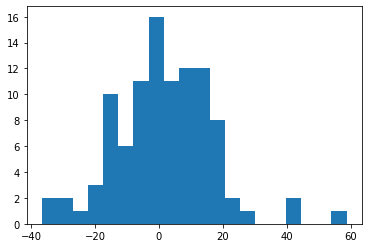

In [12]:
plt.hist(rewards, bins=20)
plt.show()

In [2]:
env2 = TradingEnv('TestEnv')
for b in range(100):
    env2.reset()
    done = False
    while not done:
        action = env2.action_space.sample()
        obs, reward, done, _ = env2.step(action)
print(env2._portfolio._history['trade_profit'].mean())
print(env2._portfolio._history)

INFO:Thread-4:numexpr.utils:NumExpr defaulting to 8 threads.


2.49
             symbol position  enter_price      enter_datetime  out_price  \
0   GBPUSD_15_close    Short      1.51302 2009-05-07 06:30:00    1.51114   
1   GBPUSD_15_close    Short      1.61930 2008-11-03 14:00:00    1.61520   
2   GBPUSD_15_close    Short      1.59250 2003-09-12 11:30:00    1.59380   
3   GBPUSD_15_close    Short      1.56404 2012-05-30 00:15:00    1.56356   
4   GBPUSD_15_close     Long      1.30021 2016-09-27 11:15:00    1.29723   
..              ...      ...          ...                 ...        ...   
95  GBPUSD_15_close     Long      1.97860 2008-04-14 20:15:00    1.97970   
96  GBPUSD_15_close     Long      1.54185 2012-07-13 10:15:00    1.54257   
97  GBPUSD_15_close    Short      1.45170 2001-08-21 23:15:00    1.45450   
98  GBPUSD_15_close     Long      1.53390 2002-08-28 02:00:00    1.53290   
99  GBPUSD_15_close     Long      1.67141 2009-11-19 08:30:00    1.67050   

          out_datetime trade_profit  trade_duration  
0  2009-05-07 07:00:00      

In [12]:
env2.reset()
(env2._portfolio._trade['done'] == True).all()

False

In [3]:
env._portfolio.clear_history()
for b in range(100):
    env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)
print(env._portfolio._history['trade_profit'].mean())
print(env._portfolio._history)

2.605
              symbol position  enter_price      enter_datetime  out_price  \
0    GBPUSD_15_close     Long      1.88200 2005-02-03 22:30:00    1.88240   
1     GBPUSD_15_open     Long      1.88250 2005-02-03 23:30:00    1.88210   
2    GBPUSD_15_close     Long      1.57206 2012-07-31 07:30:00    1.57202   
3     GBPUSD_15_open    Short      1.57213 2012-07-31 07:45:00    1.57201   
4    GBPUSD_15_close     Long      1.42116 2009-03-06 08:45:00    1.42746   
..               ...      ...          ...                 ...        ...   
195  GBPUSD_15_close    Short      1.44490 2001-10-18 13:15:00    1.44200   
196   GBPUSD_15_open    Short      1.82450 2004-06-25 00:00:00    1.82500   
197  GBPUSD_15_close    Short      1.82460 2004-06-25 00:00:00    1.82580   
198  GBPUSD_15_close     Long      1.77670 2005-09-26 21:30:00    1.77620   
199   GBPUSD_15_open     Long      1.77790 2005-09-26 22:15:00    1.77880   

           out_datetime trade_profit  trade_duration  
0   2005-02-03

In [4]:
env._portfolio._history['symbol'].value_counts()

GBPUSD_15_close    100
GBPUSD_15_open     100
Name: symbol, dtype: int64

In [11]:
mask = env2._portfolio._trade['done'].values == True
mask


array([ True])

In [18]:
env2._portfolio._trade[mask] = np.NaN

In [19]:
env2._portfolio._trade[mask]

,position,enter_price,enter_datetime,done
GBPUSD_15_close,NaN,NaN,NaN,NaN
